## SAIL-VL-1.6-8B

* From ByteDance
* Rank #10 in OpenCompass multimodal academic leaderboard for open-source model (https://rank.opencompass.org.cn/leaderboard-multimodal)

In [ ]:
# conda activate rca
'''
SAIL-VL-1d6-8B
'''
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM


IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=10, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    # Check if image_file is a URL
    if isinstance(image_file, str) and (image_file.startswith('http://') or image_file.startswith('https://')):
        response = requests.get(image_file)
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


model_path = "/data/students/earl/llava-dissector/SAIL-VL-1d6-8B"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map = 'auto',   # Partition the load across available GPUs
    trust_remote_code=True,).eval()
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)


/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type internvl_chat to instantiate a model of type sailvl. This is not supported for all configurations of models and can yield errors.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/torch/nn/modules/module.py:2400: UserWarning: for model.embed_tokens.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them i

User: <image> Give the bounding box coordinates of all instances of baseball bat in the image..
Assistant: [0.41, 0.32, 0.48, 0.51] and [0.79, 0.61, 0.82, 0.64]. These coordinates highlight the positions of baseball bats, one held by a player, and the other possibly lying on the ground.
Bounding Boxes: [[0.41, 0.32, 0.48, 0.51], [0.79, 0.61, 0.82, 0.64]]


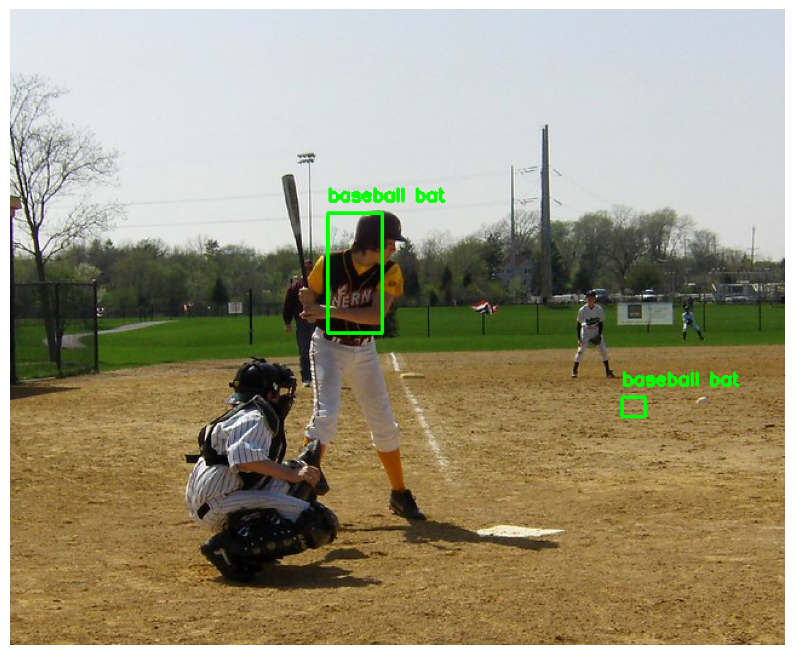

: 

In [ ]:
import io
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np
from PIL import Image
import requests

cls = "baseball bat"

model.threshold = -1.1

url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
pixel_values = load_image(url).to(torch.bfloat16)
generation_config = dict(max_new_tokens=1024, do_sample=False)

text = f'Give the bounding box coordinates of all instances of {cls} in the image.'
question = f'<image> {text}.'
#question = '<image>         Please describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

# regex the part of string to extract bounding boxes
pattern = r'\[\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*\]'
matches = re.findall(pattern, response)
bounding_boxes = [[float(coord) for coord in match] for match in matches]
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(io.BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
